In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/News Article Topic /News_Category_Dataset_v3.json'

# Load HuffPost
huff = pd.read_json(file_path, lines=True)

# Quick check
huff.head()


In [ ]:
file_path = '/content/drive/MyDrive/News Article Topic /guardian_articles.csv'

# Load HuffPost
guardian = pd.read_csv(file_path)

# Quick check
guardian.head()

Map & Standardize Columns

In [ ]:
huff.rename(columns={'headline':'title', 'short_description':'content', 'date':'published_date'}, inplace=True)
huff['source'] = 'HuffPost'
huff['article_id'] = ['HU_'+str(i+1).zfill(5) for i in range(len(huff))]

In [ ]:
guardian.rename(columns={
    'webTitle':'title',
    'bodyContent':'content',
    'sectionName':'category',
    'webPublicationDate':'published_date',
    'webUrl':'link',
    'id':'authors'
}, inplace=True)

guardian['source'] = 'Guardian'
guardian['article_id'] = ['GU_'+str(i+1).zfill(5) for i in range(len(guardian))]


In [ ]:
# HuffPost columns
print(huff.columns)

# Guardian columns
print(guardian.columns)


combine both dataset

In [ ]:
master_df = pd.concat([huff, guardian], ignore_index=True)
print(master_df.shape)
print(master_df.head())


In [ ]:
master_df.isnull().sum()


In [ ]:
master_df['content'].fillna('', inplace=True)


In [ ]:
master_df.isnull().sum()


Clean the Text

Purpose: Remove noise and prepare for topic modeling.

In [ ]:
#Remove Duplicates
print("before remove duplicates", len(master_df))
master_df.drop_duplicates(subset=['title', 'content'], inplace=True)
print("after remove dublicates" , len(master_df))

In [ ]:
#Standardize Date Format
def fix_datetime(x):
    try:
        dt = pd.to_datetime(x, errors='coerce', utc=True)  # make tz-aware consistent
        if pd.notnull(dt):
            dt = dt.tz_convert(None)  # remove timezone info → naive
        return dt
    except Exception:
        return pd.NaT

# Apply to the column
master_df['published_date'] = master_df['published_date'].apply(fix_datetime)
# Format consistently as YYYY-MM-DD
master_df['published_date'] = master_df['published_date'].dt.strftime('%Y-%m-%d')
# Check first few rows
print(master_df['published_date'].head())

In [ ]:
!pip install langdetect
from langdetect import detect
from tqdm import tqdm
tqdm.pandas()
def detect_language(text):
  try:
    return detect(text)
  except:
    return "unknown"
master_df['language'] = master_df['content'].progress_apply(detect_language)
master_df = master_df[master_df['language'] == 'en']


Remove Very Short Articles

In [ ]:
master_df['word_count']= master_df['content'].apply(lambda x: len(str(x).split()))
master_df = master_df[master_df['word_count'] >= 50]

Text Cleaning for NLP

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

master_df['clean_content'] = master_df['content'].apply(clean_text)


Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

master_df['clean_content'] = master_df['clean_content'].apply(lemmatize_text)


In [ ]:
print("Shape after all cleaning:", master_df.shape)
master_df[['title', 'clean_content', 'source']].sample(3)


In [ ]:
# Save the cleaned dataset to your drive
clean_path = '/content/drive/MyDrive/News Article Topic /cleaned_news.csv'  #  preferred path
master_df.to_csv(clean_path, index=False)

print(f"✅ Cleaned dataset saved successfully at: {clean_path}")
print("Shape:", master_df.shape)


In [ ]:
import pandas as pd

df_check = pd.read_csv('/content/drive/MyDrive/News Article Topic /cleaned_news.csv')
print("Loaded shape:", df_check.shape)
df_check.head(2)


/tmp/ipython-input-2191586280.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv('/content/drive/MyDrive/News Article Topic /cleaned_news.csv')


Loaded shape: (155405, 11)


link  \
0  https://www.huffingtonpost.com/entry/reunited_...   
1  https://www.huffingtonpost.com/entry/confessio...   

                                               title  category  \
0                                           Reunited  POLITICS   
1  Confessional: Help Me Process My Conversation ...  POLITICS   

                                             content  \
0  I grew up on the border between the United Sta...   
1  On the night of the college football champions...   

                                             authors published_date    source  \
0                                  Christine Roberts     2017-08-16  HuffPost   
1  Clinton J. Moyer, ContributorSenior Fellow, Wa...     2017-01-14  HuffPost   

  article_id language  word_count  \
0   HU_27414       en          78   
1   HU_45972       en          51   

                                       clean_content  
0  grew border united state mexico near boundary ...  
1  night college football championship game talke...

In [ ]:
# Load only first 1000 rows
import pandas as pd
df_check = pd.read_csv(
    '/content/drive/MyDrive/News Article Topic /cleaned_news.csv',
    nrows=1000,  # only 1000 rows
    dtype={
        'link': str,
        'title': str,
        'category': str,
        'content': str,
        'authors': str,
        'published_date': str,
        'source': str,
        'article_id': str,
        'language': str,
        'word_count': int,
        'clean_content': str
    },
    low_memory=False
)
print("Loaded shape (sample):", df_check.shape)
df_check.head(2)


Loaded shape (sample): (1000, 11)


link  \
0  https://www.huffingtonpost.com/entry/reunited_...   
1  https://www.huffingtonpost.com/entry/confessio...   

                                               title  category  \
0                                           Reunited  POLITICS   
1  Confessional: Help Me Process My Conversation ...  POLITICS   

                                             content  \
0  I grew up on the border between the United Sta...   
1  On the night of the college football champions...   

                                             authors published_date    source  \
0                                  Christine Roberts     2017-08-16  HuffPost   
1  Clinton J. Moyer, ContributorSenior Fellow, Wa...     2017-01-14  HuffPost   

  article_id language  word_count  \
0   HU_27414       en          78   
1   HU_45972       en          51   

                                       clean_content  
0  grew border united state mexico near boundary ...  
1  night college football championship game talke...

In [ ]:
print(df_check.isnull().sum())


link              0
title             0
category          0
content           0
authors           0
published_date    0
source            0
article_id        0
language          0
word_count        0
clean_content     0
dtype: int64


In [ ]:
df = df_check[df_check['clean_content'].notnull()]


EDA


In [ ]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/News Article Topic /cleaned_news.csv')

# 1. Basic info
print("🔹 Dataset Shape:", df.shape)
print("\n🔹 Column Names:\n", df.columns.tolist())

# 2. Check data types and non-null counts
print("\n🔹 Dataset Info:")
print(df.info())

# 3. Check for missing values
print("\n🔹 Missing Values:")
print(df.isnull().sum())

# 4. Check for duplicates
print("\n🔹 Duplicate Rows:", df.duplicated().sum())

# 5. Preview few records
print("\n🔹 Sample Rows:")
display(df.sample(5))


/tmp/ipython-input-1323972566.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/News Article Topic /cleaned_news.csv')


🔹 Dataset Shape: (155405, 11)

🔹 Column Names:
 ['link', 'title', 'category', 'content', 'authors', 'published_date', 'source', 'article_id', 'language', 'word_count', 'clean_content']

🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155405 entries, 0 to 155404
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   link            155405 non-null  object
 1   title           155405 non-null  object
 2   category        155405 non-null  object
 3   content         155405 non-null  object
 4   authors         155405 non-null  object
 5   published_date  155405 non-null  object
 6   source          155405 non-null  object
 7   article_id      155405 non-null  object
 8   language        155405 non-null  object
 9   word_count      155405 non-null  int64 
 10  clean_content   155405 non-null  object
dtypes: int64(1), object(10)
memory usage: 13.0+ MB
None

🔹 Missing Values:
link              0
title 

link  \
25980   https://www.theguardian.com/tv-and-radio/2016/...   
89259   https://www.theguardian.com/politics/2019/aug/...   
133886  https://www.theguardian.com/sport/2021/jul/25/...   
16107   https://www.theguardian.com/tv-and-radio/2016/...   
135861  https://www.theguardian.com/us-news/2021/aug/2...   

                                                    title            category  \
25980   Ben Fogle: New Lives in the Wild review – stil...  Television & radio   
89259   Rebel MPs confident they have time to stop no-...            Politics   
133886  Lions have destiny in their own hands after st...               Sport   
16107   We need more Aboriginal superheroes, so I crea...  Television & radio   
135861  Apathetic voters could hand California recall ...             US news   

                                                  content authors  \
25980   Returning for a fifth series, Ben Fogle’s New ...   19016   
89259   Cross-party rebel MPs said they had new optimi...   83078   
133886  A week can be an achingly long time in rugby, ...  128098   
16107   For as long as I can remember, I have loved fi...    9027   
135861  When Gavin Newsom was first elected governor o...  130087   

       published_date    source article_id language  word_count  \
25980      2016-10-26  Guardian   GU_19016       en         793   
89259      2019-08-30  Guardian   GU_83078       en         989   
133886     2021-07-25  Guardian  GU_128098       en         855   
16107      2016-05-27  Guardian   GU_09027       en         907   
135861     2021-08-25  Guardian  GU_130087       en         913   

                                            clean_content  
25980   returning fifth series ben fogles new life wil...  
89259   crossparty rebel mp said new optimism measure ...  
133886  week achingly long time rugby particularly bri...  
16107   long remember loved film television kid couldn...  
135861  gavin newsom first elected governor california...

🔹 Articles per Source:

source
Guardian    148220
HuffPost      7185
Name: count, dtype: int64


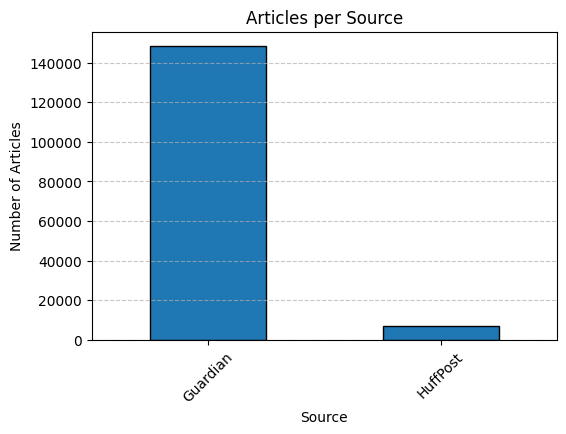

In [ ]:
#Articles per Source
import matplotlib.pyplot as plt

# Count articles by source
source_counts = df['source'].value_counts()

print("🔹 Articles per Source:\n")
print(source_counts)

# Visualization
plt.figure(figsize=(6,4))
source_counts.plot(kind='bar', edgecolor='black')
plt.title("Articles per Source")
plt.xlabel("Source")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


🔹 Top 15 Categories:

category
World news        15466
Opinion           11954
Football          10720
Sport             10250
Australia news     7797
US news            7449
Politics           7045
Business           6979
UK news            6474
Music              5750
Life and style     5366
Books              5101
Film               4978
Environment        4864
Society            4703
Name: count, dtype: int64


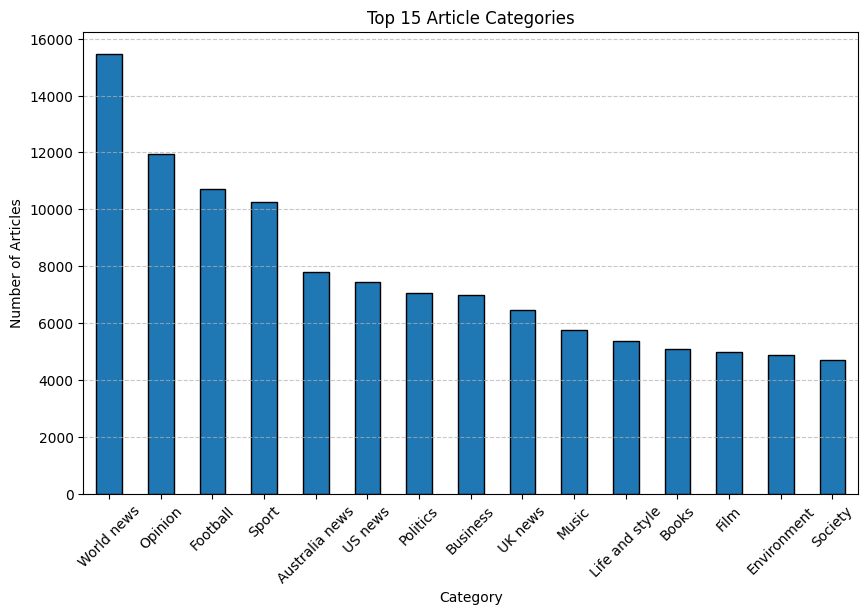

In [ ]:
#Articles per Category
# Count categories
category_counts = df['category'].value_counts().head(15)

print("🔹 Top 15 Categories:\n")
print(category_counts)

# Visualization
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', edgecolor='black')
plt.title("Top 15 Article Categories")
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


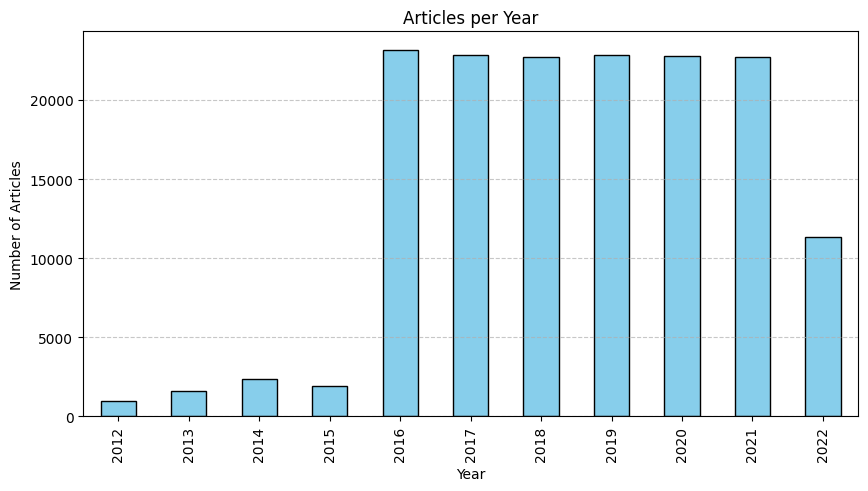

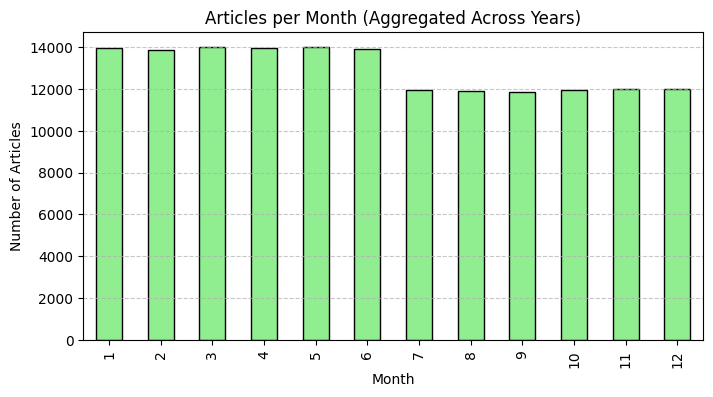

In [ ]:
#Temporal Analysis (Articles over Time)
# Ensure published_date is datetime
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

# Extract year and month
df['year'] = df['published_date'].dt.year
df['month'] = df['published_date'].dt.month

# --- Articles per Year ---
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Articles per Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Articles per Month (overall) ---
month_counts = df['month'].value_counts().sort_index()

plt.figure(figsize=(8,4))
month_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Articles per Month (Aggregated Across Years)")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


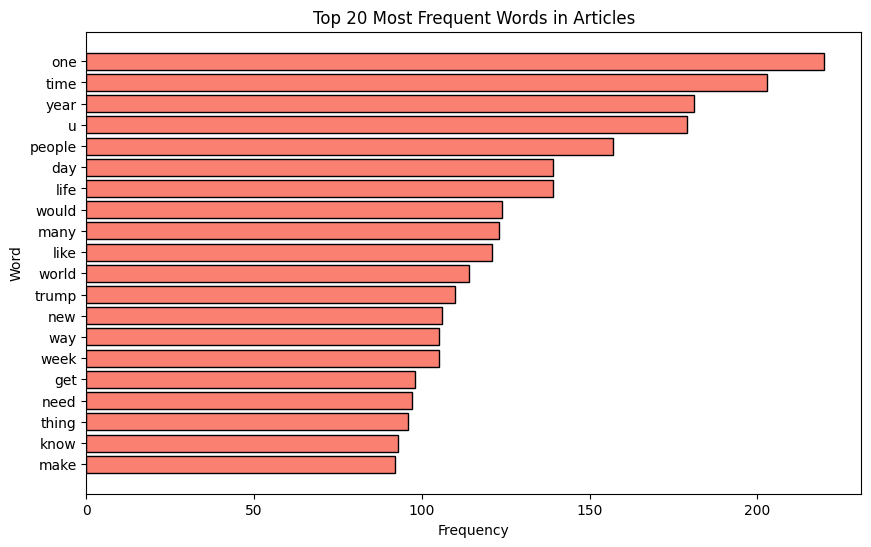

In [ ]:
#Word Frequency Analysis
from collections import Counter
import matplotlib.pyplot as plt

# Combine all clean content
all_words = ' '.join(df_check['clean_content'].astype(str)).split()

# Count word frequencies
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

# Create dataframe for plotting
import pandas as pd
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

# Plot top 20 words
plt.figure(figsize=(10,6))
plt.barh(top_words_df['word'][::-1], top_words_df['count'][::-1], color='salmon', edgecolor='black')
plt.title("Top 20 Most Frequent Words in Articles")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


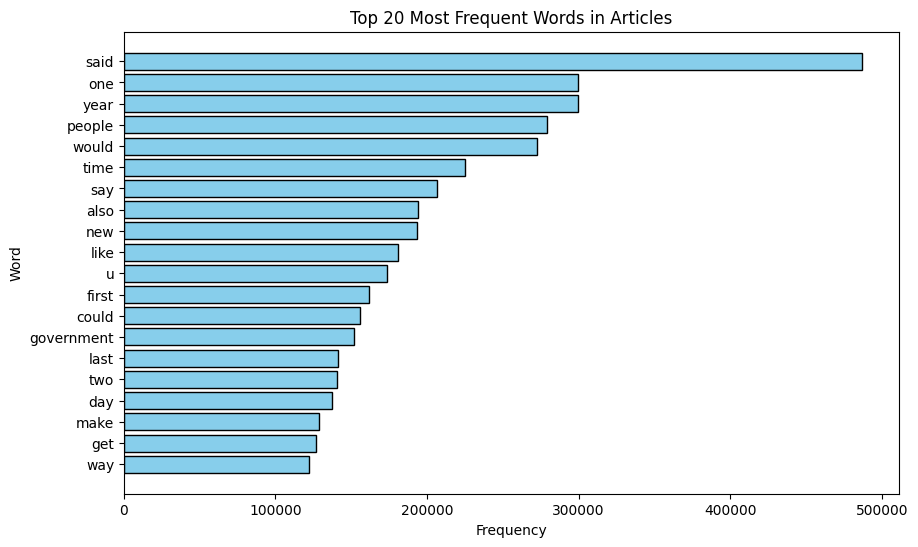

🔹 Top 20 Most Frequent Words:
          word   count
0         said  486965
1          one  299762
2         year  299313
3       people  278883
4        would  272243
5         time  225244
6          say  206377
7         also  194232
8          new  193421
9         like  180652
10           u  173673
11       first  161470
12       could  155528
13  government  151789
14        last  141566
15         two  140292
16         day  137121
17        make  128422
18         get  126676
19         way  121921


In [ ]:
#Word Frequency Analysis using your cleaned dataset:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Combine all lemmatized & cleaned text
all_words = ' '.join(df['clean_content'].astype(str)).split()

# Count word frequencies
word_freq = Counter(all_words)

# Get top 20 most common words
top_words = word_freq.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

# Plot top 20 words
plt.figure(figsize=(10,6))
plt.barh(top_words_df['word'][::-1], top_words_df['count'][::-1], color='skyblue', edgecolor='black')
plt.title("Top 20 Most Frequent Words in Articles")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Optional: display the top words as table
print("🔹 Top 20 Most Frequent Words:")
print(top_words_df)


Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10  # adjust as needed

# Convert text to document-term matrix
vectorizer = CountVectorizer(
    max_df=0.95,    # ignore very common words
    min_df=10,      # ignore rare words
    stop_words='english'
)
X = vectorizer.fit_transform(df['clean_content'])


Train LDA Model

In [ ]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)


LatentDirichletAllocation(random_state=42)

In [ ]:
def print_lda_topics(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ", [feature_names[i] for i in topic.argsort()[-top_n:][::-1]])

print_lda_topics(lda, vectorizer)


Topic 0:  ['game', 'player', 'team', 'league', 'club', 'season', 'england', 'time', 'football', 'said']
Topic 1:  ['people', 'child', 'year', 'say', 'work', 'school', 'said', 'woman', 'need', 'home']
Topic 2:  ['said', 'police', 'court', 'people', 'told', 'case', 'year', 'law', 'government', 'state']
Topic 3:  ['year', 'said', 'time', 'world', 'sport', 'day', 'russian', 'race', 'russia', 'team']
Topic 4:  ['year', 'say', 'water', 'said', 'food', 'climate', 'new', 'world', 'people', 'change']
Topic 5:  ['like', 'art', 'year', 'london', 'music', 'work', 'city', 'new', 'time', 'artist']
Topic 6:  ['like', 'say', 'time', 'year', 'people', 'life', 'thing', 'film', 'woman', 'story']
Topic 7:  ['said', 'government', 'year', 'company', 'australia', 'new', 'business', 'uk', 'bn', 'tax']
Topic 8:  ['party', 'trump', 'said', 'labour', 'election', 'eu', 'brexit', 'people', 'minister', 'vote']
Topic 9:  ['said', 'people', 'health', 'covid', 'day', 'hospital', 'case', 'new', 'pandemic', 'week']


In [ ]:
import joblib

# Save LDA model
joblib.dump(lda, "lda_model.joblib")

# Save the CountVectorizer too (needed to transform new data)
joblib.dump(vectorizer, "vectorizer.joblib")


['vectorizer.joblib']

In [ ]:
import joblib

# Load LDA model
lda = joblib.load("/content/drive/MyDrive/News Article Topic/lda_model.joblib")

# Load the vectorizer
vectorizer = joblib.load("/content/drive/MyDrive/News Article Topic/vectorizer.joblib")


In [ ]:
import os
import joblib

# Path to save models
save_path = "/content/drive/MyDrive/News Article Topic"

# Create the folder if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save LDA model and vectorizer
joblib.dump(lda, os.path.join(save_path, "lda_model.joblib"))
joblib.dump(vectorizer, os.path.join(save_path, "vectorizer.joblib"))

print("Models saved successfully!")


Models saved successfully!


Option 2: BERTopic (Modern NLP Approach)

In [ ]:
!pip install bertopic


In [ ]:
!pip install bertopic sentence-transformers
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic


In [ ]:
df_check = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")
df = df_check[df_check['clean_content'].notnull()]


/tmp/ipython-input-166653877.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_check = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")


In [ ]:
from bertopic import BERTopic
import pandas as pd

# Load cleaned data
df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")
df = df[df['clean_content'].notnull()]

# Take a smaller sample
df_sample = df.sample(20000, random_state=42)

# Initialize and fit BERTopic
topic_model = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2")
topics, probs = topic_model.fit_transform(df_sample['clean_content'])

# View topics
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))


/tmp/ipython-input-1518968476.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")


   Topic  Count                                   Name  \
0     -1   6964                 -1_people_said_one_say   
1      0   1087               0_labour_brexit_eu_party   
2      1    570   1_trump_republican_president_clinton   
3      2    432  2_labor_australian_australia_morrison   
4      3    413                3_album_song_band_music   
5      4    393           4_film_movie_actor_character   
6      5    371       5_bank_company_customer_business   
7      6    222                6_book_novel_story_read   
8      7    209            7_cricket_england_test_ball   
9      8    202         8_russian_ukraine_russia_putin   

                                      Representation  \
0  [people, said, one, say, year, like, time, wou...   
1  [labour, brexit, eu, party, johnson, tory, mp,...   
2  [trump, republican, president, clinton, democr...   
3  [labor, australian, australia, morrison, turnb...   
4  [album, song, band, music, pop, track, guitar,...   
5  [film, movie, actor, c

Due to hardware limitations, BERTopic was trained on a smaller subset (20k samples),
while LDA was applied on the full dataset.
Both models were then compared to analyze topic quality and scalabilit

In [ ]:
topic_model.save("/content/drive/MyDrive/News Article Topic/bertopic_model")


NameError: name 'topic_model' is not defined

In [ ]:
!pip install bertopic

from bertopic import BERTopic
topic_model = BERTopic.load("/content/drive/MyDrive/News Article Topic/bertopic_model")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# --- VISUALIZE BERTopic TOPICS ---
print("\nGenerating BERTopic visualizations... (may take a minute)")

# Show each visualization separately
fig1 = topic_model.visualize_topics()
fig1.show()

fig2 = topic_model.visualize_barchart()
fig2.show()

fig3 = topic_model.visualize_hierarchy()
fig3.show()

fig4 = topic_model.visualize_heatmap()
fig4.show()



Generating BERTopic visualizations... (may take a minute)


In [ ]:
# Step 1: Install pyLDAvis if not installed
!pip install pyLDAvis --quiet


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [ ]:
!pip install pyLDAvis==3.4.1 --quiet


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [ ]:
import pandas as pd

# Load cleaned data
df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")
df = df[df['clean_content'].notnull()]

# Take a smaller sample (optional)
df_sample = df.sample(5000, random_state=42)

# Transform clean_content using the loaded vectorizer
X = vectorizer.transform(df_sample['clean_content'])


/tmp/ipython-input-1715453621.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")


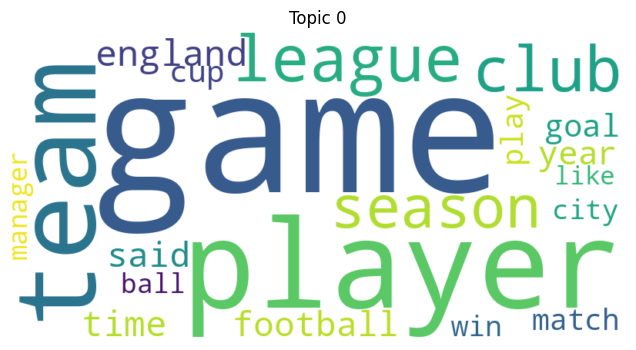

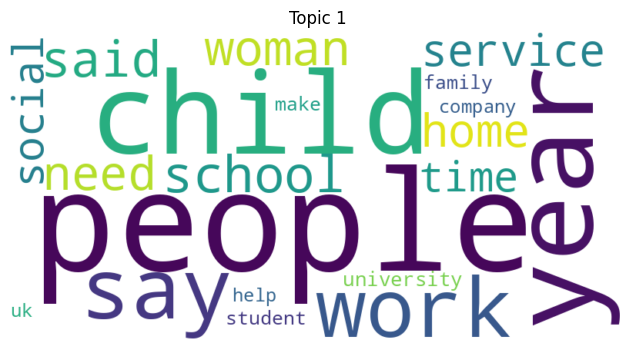

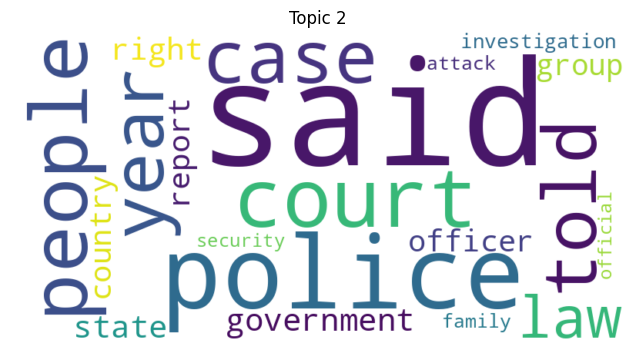

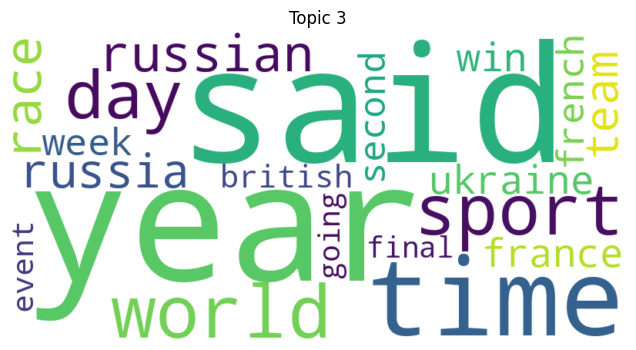

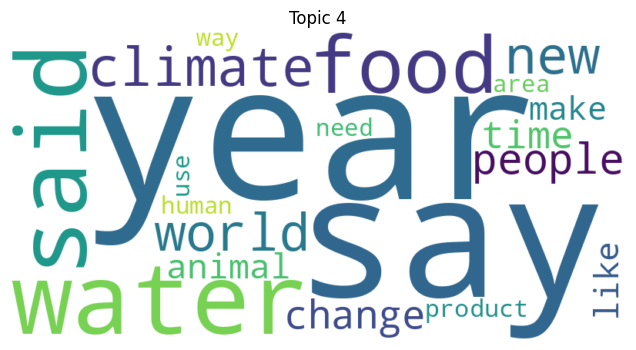

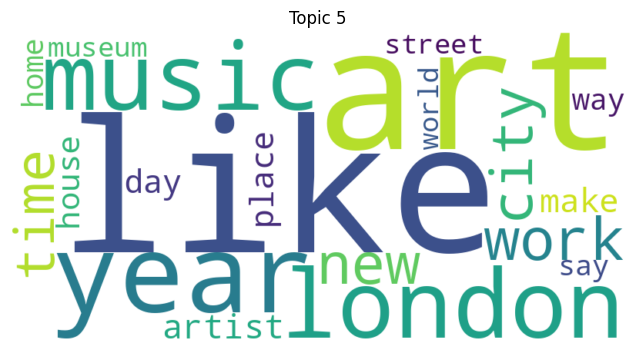

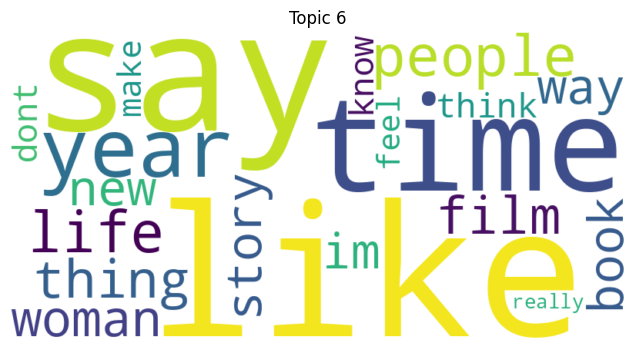

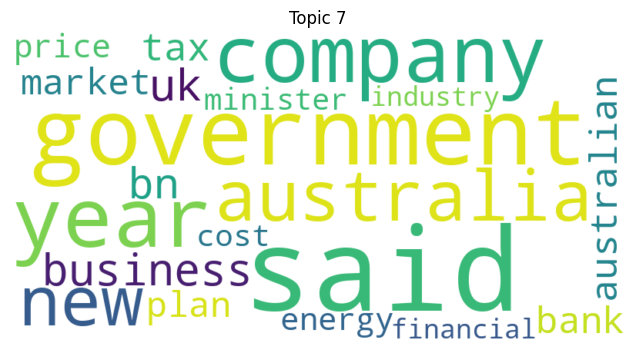

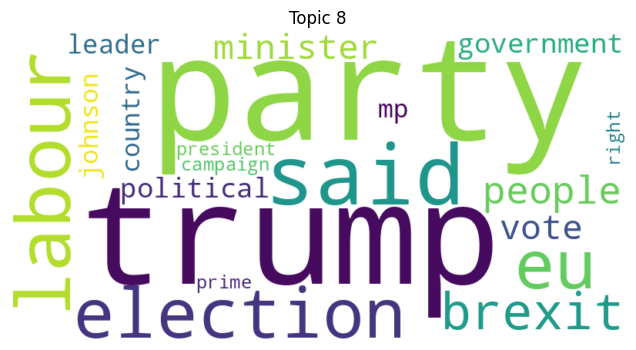

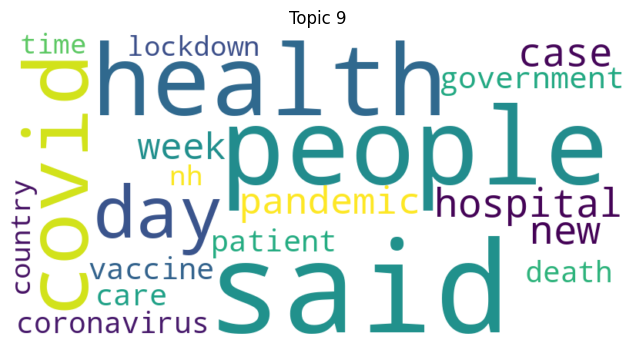

In [ ]:
#Word Clouds per Topic (Lightweight)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_wordclouds(lda_model, vectorizer, n_words=20):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        plt.figure(figsize=(8,4))
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-n_words:]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {idx}')
        plt.show()

plot_lda_wordclouds(lda, vectorizer)


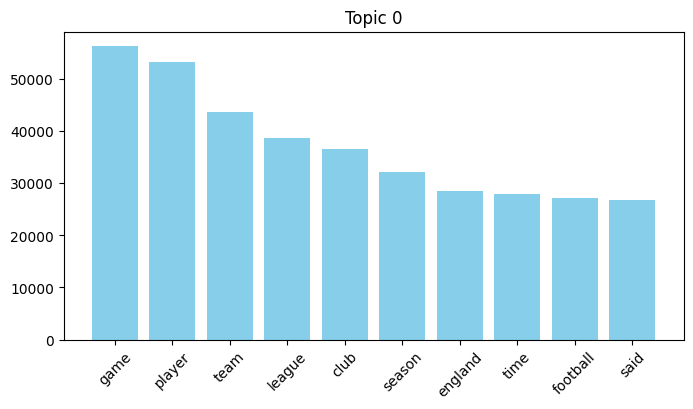

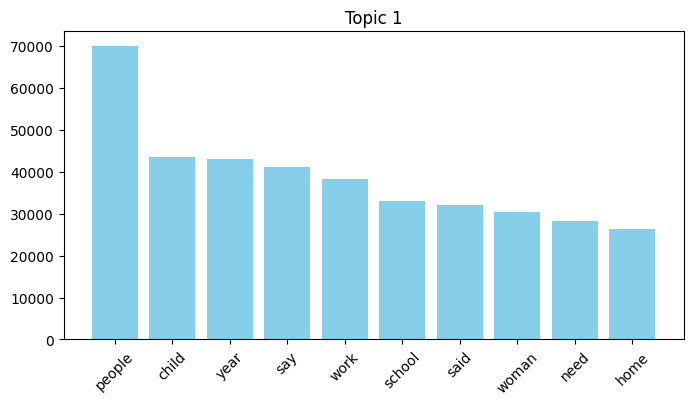

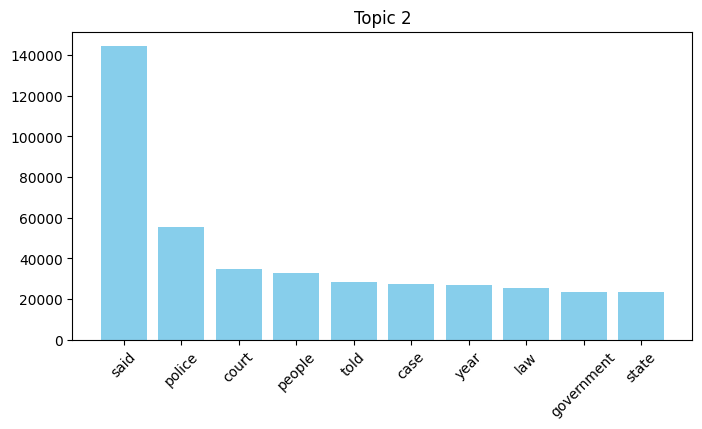

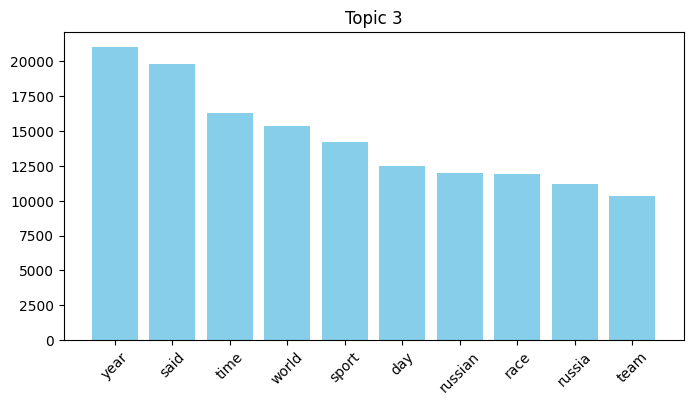

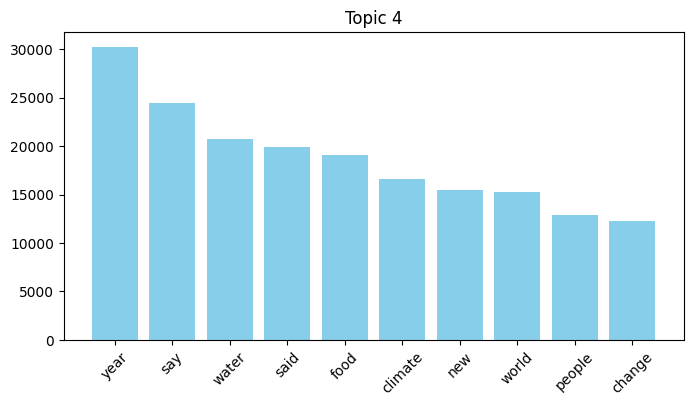

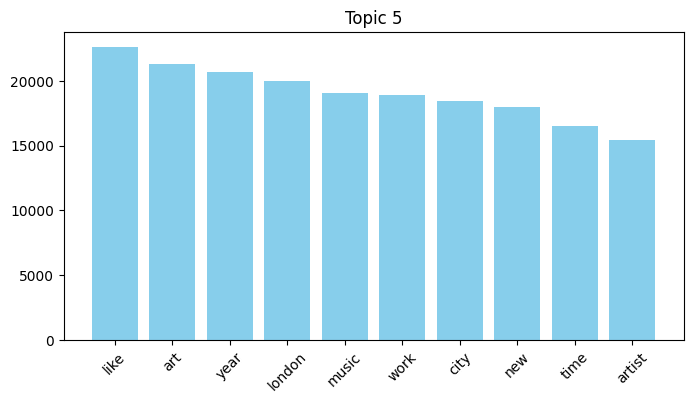

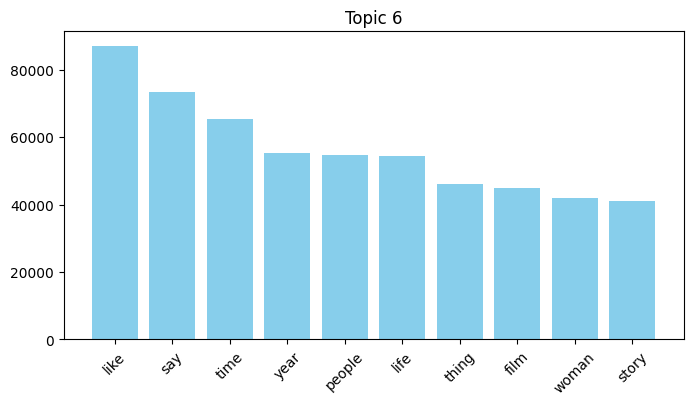

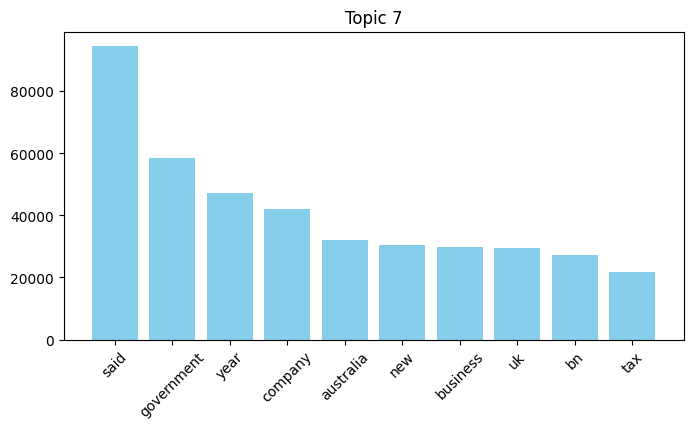

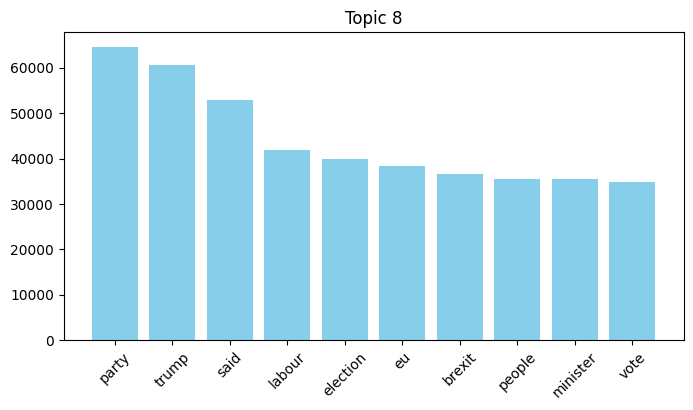

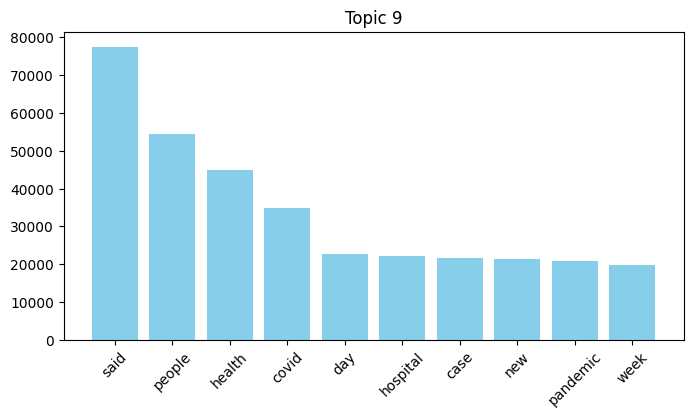

In [ ]:
import matplotlib.pyplot as plt

def plot_lda_bars(lda_model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]

        plt.figure(figsize=(8,4))
        plt.bar(top_words, top_values, color='skyblue')
        plt.title(f'Topic {idx}')
        plt.xticks(rotation=45)
        plt.show()

plot_lda_bars(lda, vectorizer)


In [ ]:
import pandas as pd
import joblib

# Step 1: Load cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")
df = df[df['clean_content'].notnull()]  # ensure no nulls

# Step 2: Load saved LDA model and vectorizer
lda = joblib.load("/content/drive/MyDrive/News Article Topic/lda_model.joblib")
vectorizer = joblib.load("/content/drive/MyDrive/News Article Topic/vectorizer.joblib")

# Step 3: Transform clean content to bag-of-words matrix
X = vectorizer.transform(df['clean_content'])

# Step 4: Get topic distributions
topic_distribution = lda.transform(X)

# Step 5: Assign most probable topic to each article
df['lda_topic'] = topic_distribution.argmax(axis=1)

# Step 6: Summarize topic counts
topic_counts = df['lda_topic'].value_counts().sort_index()
print("Articles per topic:")
print(topic_counts)

# Step 7: Save new dataframe with topics
output_path = "/content/drive/MyDrive/News Article Topic/news_with_lda_topics.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Saved dataset with LDA topics at: {output_path}")


/tmp/ipython-input-4196449028.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/News Article Topic /cleaned_news.csv")


Articles per topic:
lda_topic
0    15274
1    16680
2    19307
3     5479
4     8882
5    14261
6    34910
7    14008
8    16869
9     9735
Name: count, dtype: int64

✅ Saved dataset with LDA topics at: /content/drive/MyDrive/News Article Topic/news_with_lda_topics.csv


In [ ]:
# Function to print top words per topic
def print_top_words(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Print top 10 words per topic
print_top_words(lda, vectorizer, n_top_words=10)


Topic 0: game, player, team, league, club, season, england, time, football, said
Topic 1: people, child, year, say, work, school, said, woman, need, home
Topic 2: said, police, court, people, told, case, year, law, government, state
Topic 3: year, said, time, world, sport, day, russian, race, russia, team
Topic 4: year, say, water, said, food, climate, new, world, people, change
Topic 5: like, art, year, london, music, work, city, new, time, artist
Topic 6: like, say, time, year, people, life, thing, film, woman, story
Topic 7: said, government, year, company, australia, new, business, uk, bn, tax
Topic 8: party, trump, said, labour, election, eu, brexit, people, minister, vote
Topic 9: said, people, health, covid, day, hospital, case, new, pandemic, week


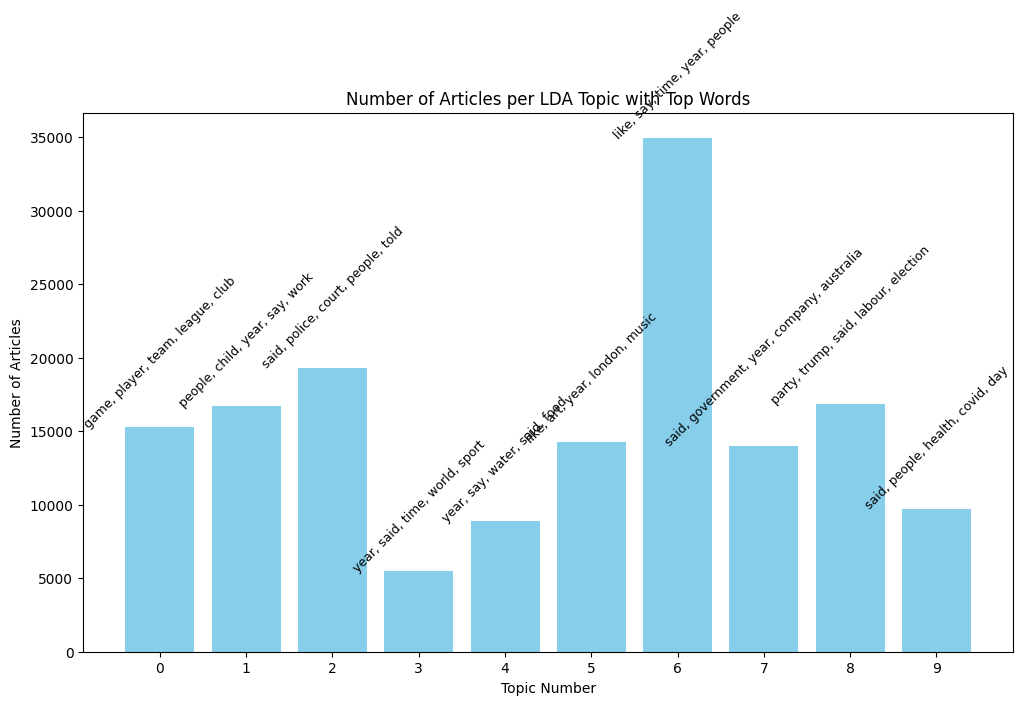

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to get top words for each topic
def get_top_words(model, vectorizer, n_top_words=5):
    feature_names = vectorizer.get_feature_names_out()
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words_per_topic.append(", ".join(top_features))
    return top_words_per_topic

# Get top words
top_words = get_top_words(lda, vectorizer)

# Dominant topic for each document
dominant_topics = np.argmax(lda.transform(X), axis=1)

# Count of documents per topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

# Plot
plt.figure(figsize=(12,7))
bars = plt.bar(topic_counts.index, topic_counts.values, color='skyblue')
plt.xlabel("Topic Number")
plt.ylabel("Number of Articles")
plt.title("Number of Articles per LDA Topic with Top Words")
plt.xticks(topic_counts.index)

# Add top words as labels on each bar
for idx, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, top_words[idx],
             ha='center', rotation=45, fontsize=9)

plt.show()


In [ ]:
# bert analysis


# View topic info
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))  # Top 10 topics


   Topic  Count                                   Name  \
0     -1   6964                 -1_people_said_one_say   
1      0   1087               0_labour_brexit_eu_party   
2      1    570   1_trump_republican_president_clinton   
3      2    432  2_labor_australian_australia_morrison   
4      3    413                3_album_song_band_music   
5      4    393           4_film_movie_actor_character   
6      5    371       5_bank_company_customer_business   
7      6    222                6_book_novel_story_read   
8      7    209            7_cricket_england_test_ball   
9      8    202         8_russian_ukraine_russia_putin   

                                      Representation  \
0  [people, said, one, say, year, like, time, wou...   
1  [labour, brexit, eu, party, johnson, tory, mp,...   
2  [trump, republican, president, clinton, democr...   
3  [labor, australian, australia, morrison, turnb...   
4  [album, song, band, music, pop, track, guitar,...   
5  [film, movie, actor, c

In [ ]:
#Assign topics to the full dataset
full_topics, full_probs = topic_model.transform(df['clean_content'])
df['bert_topic'] = full_topics


In [ ]:
# save both ssigned topics
df.to_csv("/content/drive/MyDrive/News Article Topic/news_with_topics.csv", index=False)
print("✅ Dataset with topics saved successfully!")



✅ Dataset with topics saved successfully!


In [ ]:
df['lda_topic'].value_counts()
df['bert_topic'].value_counts()


bert_topic
-1      71554
 0       8405
 1       3936
 2       3039
 5       2554
        ...  
 204       28
 224       28
 220       27
 214       25
 219       21
Name: count, Length: 227, dtype: int64

/tmp/ipython-input-220446301.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/News Article Topic/news_with_topics.csv")


bert_topic   -1     0     1     2     3     4     5     6     7     8    ...  \
lda_topic                                                                ...   
0            7209    15     7     6     1     1     0     0  1527     5  ...   
1            8420   345    46   160     9     5   515     2     9    25  ...   
2            8700   216   853   547     9     5    54     0    15   752  ...   
3             785    25     5     3     1     1     1     0    14   317  ...   
4            4035    17    10     9     3     3    13     1     8    21  ...   
5            6219   115    26    50   605    46     6    24     6    48  ...   
6           21426   572   615   259  1317  2029    19   906    58   110  ...   
7            5550   460    83  1108     3     6  1914     0    13   136  ...   
8            3727  6560  2267   809     1     1    28     1     3   234  ...   
9            5483    80    24    88     1     1     4     0     6    14  ...   

bert_topic   216   217   218   219   22

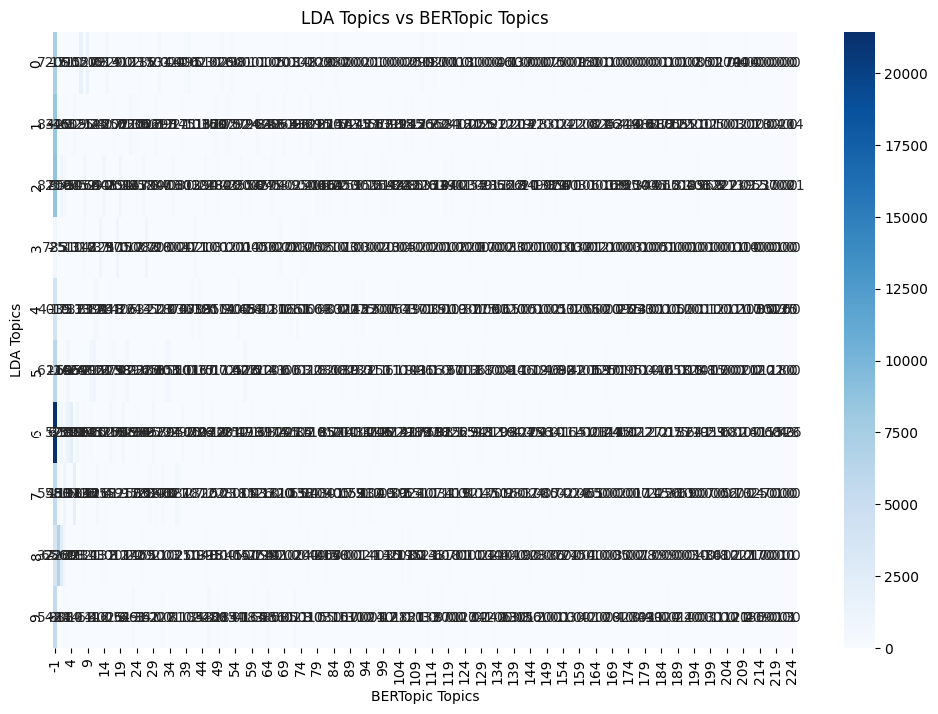

In [ ]:
# compare ldstopic vs bert topic
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset with topic assignments
df = pd.read_csv("/content/drive/MyDrive/News Article Topic/news_with_topics.csv")

# Crosstab to see overlap
topic_comparison = pd.crosstab(df['lda_topic'], df['bert_topic'])
print(topic_comparison)

# Heatmap to visualize topic overlap
plt.figure(figsize=(12,8))
sns.heatmap(topic_comparison, annot=True, fmt='d', cmap='Blues')
plt.title("LDA Topics vs BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("LDA Topics")
plt.show()


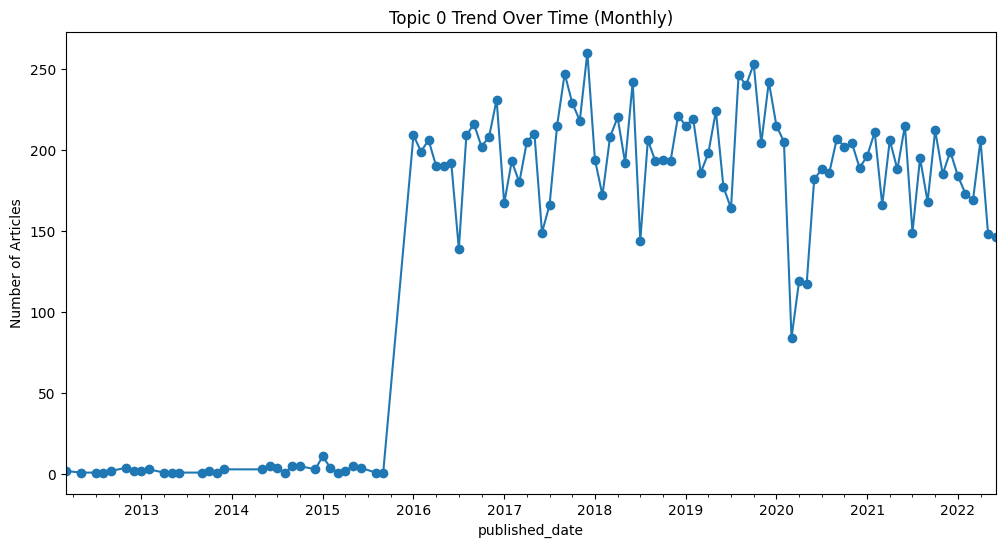

In [ ]:
#Trend Analysis (Topics over Time)
# Convert published_date to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

# Example: LDA topic 0 trend over time (monthly)
topic_trend = df[df['lda_topic']==0].groupby(df['published_date'].dt.to_period('M')).size()

# Plot
topic_trend.plot(figsize=(12,6), marker='o', title="Topic 0 Trend Over Time (Monthly)")
plt.ylabel("Number of Articles")
plt.show()


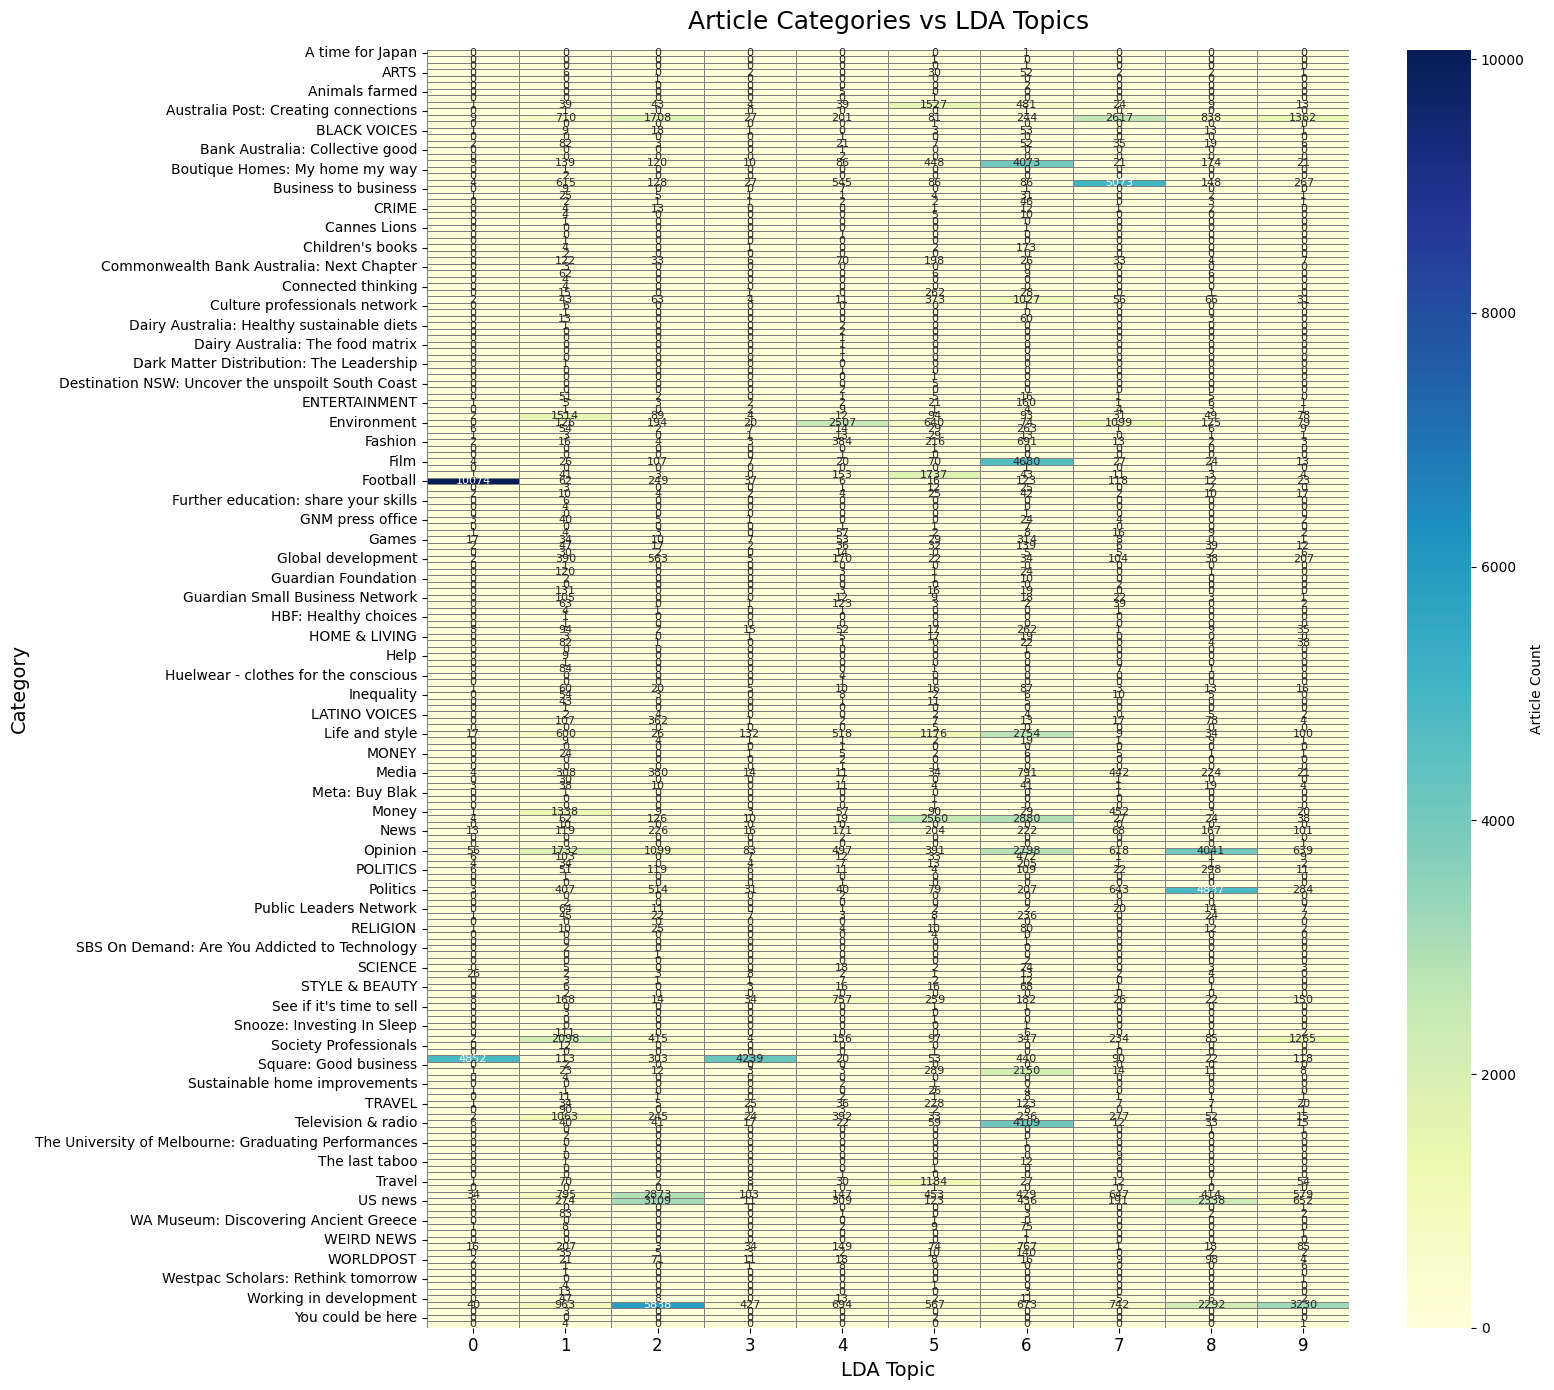

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(
    category_crosstab,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 8},   # smaller numbers for less overlap
    cbar_kws={'label': 'Article Count'}  # colorbar label
)

plt.title("Article Categories vs LDA Topics", fontsize=18, pad=15)
plt.ylabel("Category", fontsize=14)
plt.xlabel("LDA Topic", fontsize=14)
plt.yticks(fontsize=10, rotation=0)   # upright category labels, smaller font
plt.xticks(fontsize=12)

plt.tight_layout()
plt.show()


intraprations   
Politics → dominated by election, government, party topics

Sports → match, team, score topics

Opinion / Lifestyle → topics like life, people, story

Interpretation: Y can see which topics are unique to a category and which span multiple categories.
Trends / Insights

Some topics are time-sensitive (like Ukraine-Russia news in 2022).

Some topics are cross-cutting (like “people said”, “life”, “story”) appearing in multiple categories.

Businesses or news agencies could use this to:

Track trending topics in different categories.

Understand audience interests in each category.

Automate content tagging.

In [ ]:
# LDA Evalaution
!pip install gensim

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import numpy as np

# Prepare data for gensim
texts = [doc.split() for doc in df_sample['clean_content'].astype(str)]

# Create dictionary and corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Get LDA topics as word lists
lda_topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]  # top 10 words
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    lda_topics.append(top_words)

# Calculate coherence
coherence_model_lda = CoherenceModel(topics=lda_topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"LDA Topic Coherence: {coherence_lda:.4f}")


LDA Topic Coherence: 0.4765


In [ ]:
0.4765 is a decent score for a large, real-world dataset.

Not perfect, but it means most topics are moderately meaningful.

Higher coherence (~0.6–0.8) = very clear, distinct topics.

Lower coherence (<0.4) = topics are messy or overlapping.


The topic modeling of news articles reveals trends and patterns that can help businesses understand public interest, media coverage, and emerging topics. For example, frequent mentions of “government,” “policy,” or “market” in business-related topics indicate areas of regulatory or economic focus. Companies can use these insights to track industry trends, anticipate market changes, tailor marketing strategies, and make data-driven decisions based on what topics are gaining attention in the media.